In [20]:
# Installation of Hadoop
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/hadoop/core/hadoop-2.9.2/hadoop-2.9.2.tar.gz
!tar -xzf hadoop-2.9.2.tar.gz
!mv hadoop-2.9.2 /usr/local/hadoop
!rm hadoop-2.9.2.tar.gz

# Setting HADOOP_HOME environment
import os
os.environ["HADOOP_HOME"] = "/usr/local/hadoop"

# Setting JAVA_HOME environment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Also add hadoop binaries to path
os.environ["PATH"] = os.environ["HADOOP_HOME"] + "/bin:" + os.environ["PATH"]

# Check whether hadoop is correctly installed or not
!hadoop version


mv: cannot move 'hadoop-2.9.2' to '/usr/local/hadoop/hadoop-2.9.2': Directory not empty
Hadoop 2.9.2
Subversion https://git-wip-us.apache.org/repos/asf/hadoop.git -r 826afbeae31ca687bc2f8471dc841b66ed2c6704
Compiled by ajisaka on 2018-11-13T12:42Z
Compiled with protoc 2.5.0
From source with checksum 3a9939967262218aa556c684d107985
This command was run using /usr/local/hadoop/share/hadoop/common/hadoop-common-2.9.2.jar


In [23]:
# Create a directory in HDFS
!$HADOOP_HOME/bin/hdfs dfs -mkdir /group19dir

# After that copy the file from local file system to Hadoop distributed file system (HDFS)
!$HADOOP_HOME/bin/hdfs dfs -put /content/spotifydataset.csv /group19dir

mkdir: `/group19dir': File exists
put: `/content/spotifydataset.csv': No such file or directory


In [65]:
#Installation of Pyspark
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, desc, count, countDistinct
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Starting the spark session
spark=SparkSession.builder.appName('MusicStreamingAnalysis').getOrCreate()

# Give the HDFS path in spark to retrieve data from HDFS
hdfs_path = "/group19dir/spotifydataset.csv"
df = spark.read.csv("file://" + hdfs_path, header=True, inferSchema=True)

In [66]:
#1. Popular genres are listed below through average calculation
result1 = (
    df.groupBy("genre")
    .agg(avg("popularity").alias("avg_popularity"))
    .orderBy(desc("avg_popularity"))
)
result1.show()

+---------+------------------+
|    genre|    avg_popularity|
+---------+------------------+
|      pop| 54.92777777777778|
|     rock|47.396694214876035|
|  hip-hop|43.965272856130404|
|    dance|42.910438144329895|
| alt-rock|39.297061524334254|
|    metal| 37.90817790530846|
|indie-pop| 37.88085676037483|
|  electro|36.243872549019606|
|     folk| 33.51176051318603|
|  country|30.193825042881645|
|    house|30.192182410423452|
|     punk|29.916666666666668|
|      sad|29.045161290322582|
|     jazz|27.486593059936908|
|    k-pop|26.670407560543413|
|      edm|25.423694779116467|
|   french| 24.99867724867725|
|    chill|24.559497816593886|
|     soul|24.308755760368662|
|classical| 23.88139825218477|
+---------+------------------+
only showing top 20 rows



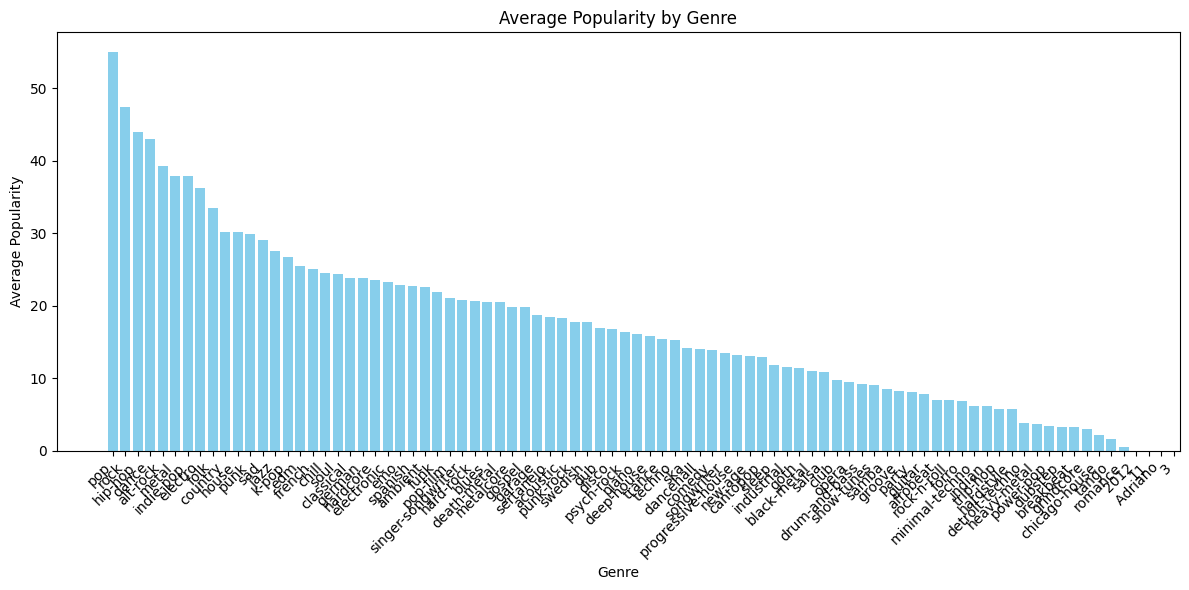

In [67]:
# Visualizing the query
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
result1_data = result1.filter(col("genre").isNotNull()).toPandas()
plt.figure(figsize=(12, 6))
plt.bar(result1_data['genre'], result1_data['avg_popularity'], color='skyblue')
plt.title('Average Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [68]:
# 2. Top 5 artists are displayed based on their tracks count
result2 = (
    df.groupBy("artist_name")
    .agg(count("track_id").alias("track_count"))
    .orderBy(desc("track_count"))
    .limit(5)
)
result2.show()

+-------------+-----------+
|  artist_name|track_count|
+-------------+-----------+
|    Glee Cast|        357|
|Nature Sounds|        277|
|Roberto Firpo|        266|
|Grateful Dead|        264|
|Massage Tribe|        227|
+-------------+-----------+



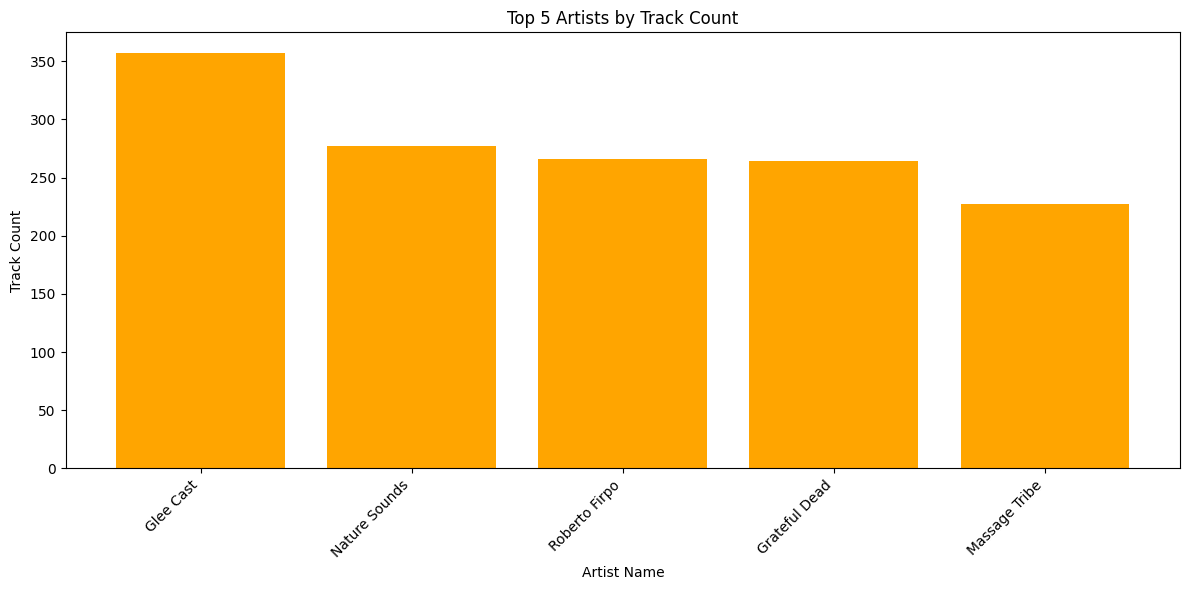

In [69]:
# Visualizing the query
from pyspark.sql.functions import desc
result2_data = result2.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(result2_data['artist_name'], result2_data['track_count'], color='orange')
plt.title('Top 5 Artists by Track Count')
plt.xlabel('Artist Name')
plt.ylabel('Track Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [70]:
# 3. Trends in music are identified by knowing the time signatures count
result3 = (
    df.groupBy("time_signature")
    .agg(count("*").alias("count"))
    .orderBy(desc("count"))
)
result3.show()

+--------------+------+
|time_signature| count|
+--------------+------+
|          NULL|922367|
|           4.0| 96290|
|           3.0| 10248|
|           5.0|  2044|
|           1.0|  1168|
|           0.0|    88|
|       70920.0|     2|
|         0.186|     2|
|       133.726|     1|
|        102.62|     1|
|      231089.0|     1|
|      106720.0|     1|
|      144827.0|     1|
|      139953.0|     1|
|      502160.0|     1|
|      296467.0|     1|
|      159267.0|     1|
|      348213.0|     1|
|      106853.0|     1|
|      145320.0|     1|
+--------------+------+
only showing top 20 rows



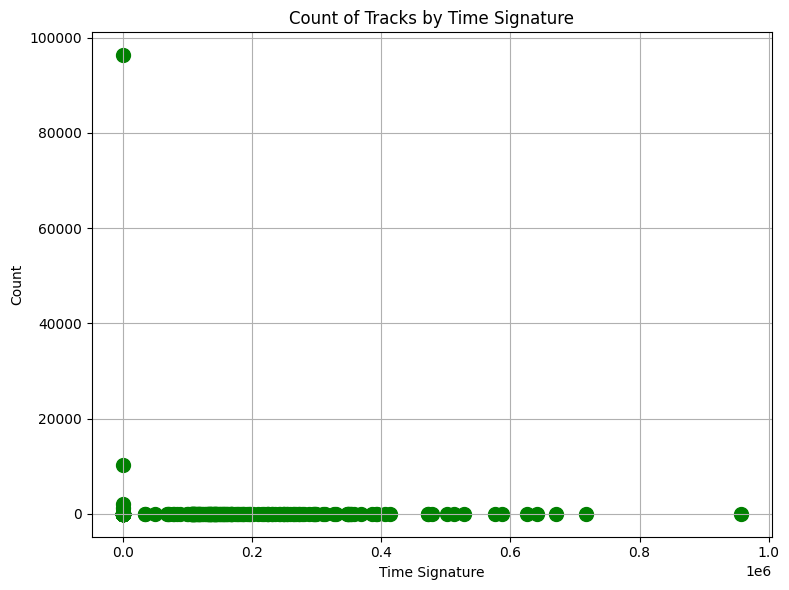

In [71]:
# Visualizing the query
result3_data = result3.toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(result3_data['time_signature'], result3_data['count'], color='green', s=100)
plt.title('Count of Tracks by Time Signature')
plt.xlabel('Time Signature')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
# 4. Prediction of poularity based on average acousticness produced at each mode
result4 = (
    df.groupBy("mode")
    .agg(avg("popularity").alias("avg_popularity"), avg("acousticness").alias("avg_acousticness"))
)
result4.show()

+-------+--------------+-------------------+
|   mode|avg_popularity|   avg_acousticness|
+-------+--------------+-------------------+
|-25.177|          NULL|                0.0|
| -9.387|          NULL|                1.0|
|-17.887|          NULL|                0.0|
|-23.599|          NULL|                1.0|
|      7|          NULL|           -14.8105|
|-20.631|          NULL|                1.0|
|-22.162|          NULL|                1.0|
|-14.622|          NULL|                1.0|
| -9.296|          NULL|                0.0|
|-13.986|          NULL|                1.0|
| -9.902|          NULL|                1.0|
|   2012|          NULL|               NULL|
|     11|          NULL|-25.256999999999998|
|-22.917|          NULL|                0.0|
|-11.334|          NULL|                1.0|
|-11.754|          NULL|                1.0|
|-12.327|          NULL|                1.0|
|-20.893|          NULL|                1.0|
| -9.124|          NULL|                1.0|
|-14.013| 

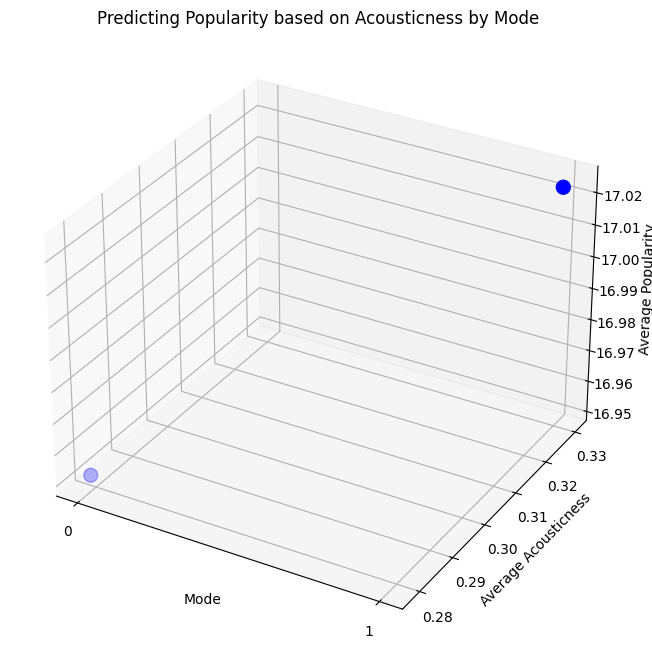

In [73]:
# Visualizing the query
from mpl_toolkits.mplot3d import Axes3D
result4_data = result4.toPandas()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result4_data['mode'], result4_data['avg_acousticness'], result4_data['avg_popularity'], c='blue', s=100)
ax.set_xlabel('Mode')
ax.set_ylabel('Average Acousticness')
ax.set_zlabel('Average Popularity')
ax.set_title('Predicting Popularity based on Acousticness by Mode')
plt.show()

In [74]:
# 5. List the top 3 tracks with highest valence
window_spec = Window.orderBy(desc("valence"))
result5 = (
    df.withColumn("rank", row_number().over(window_spec))
    .filter("rank <= 3")
    .select("artist_name", "track_name", "valence")
)
result5.show()

+--------------+--------------------+-------+
|   artist_name|          track_name|valence|
+--------------+--------------------+-------+
|Richard Wagner|"Wagner: Rienzi, ...|    3.0|
|Richard Wagner|"Wagner: Rienzi, ...|    1.0|
|Cyrillus Kreek|"Taaveti laul 104...|    1.0|
+--------------+--------------------+-------+



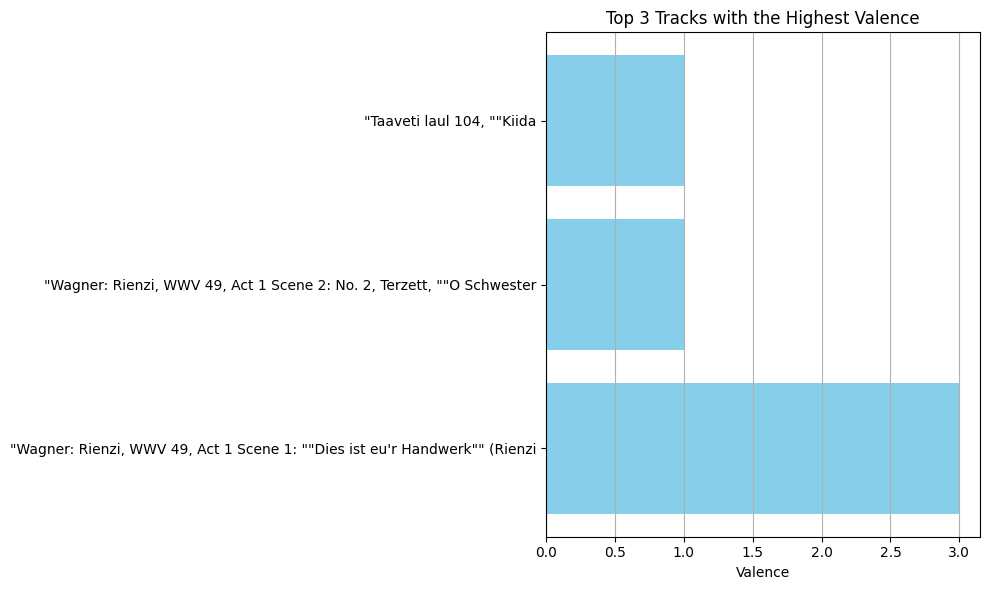

In [75]:
# Visualizing the query
result5_data = result5.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(result5_data['track_name'], result5_data['valence'], color='skyblue')
plt.xlabel('Valence')
plt.title('Top 3 Tracks with the Highest Valence')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [76]:
# 6. Calculate the avearge popularity by year to know user behavior
result6 = (
    df.groupBy("year")
    .agg(avg("popularity").alias("avg_popularity"))
    .orderBy("year")
)
result6.show()

+--------------------+--------------+
|                year|avg_popularity|
+--------------------+--------------+
|                NULL|          NULL|
|    ""Bless the Lord|          NULL|
| Al Escondite Ing...|          NULL|
|          Baroncelli|          NULL|
|              Carmen|          NULL|
|               Cecco|          NULL|
|             Colonna|          NULL|
|           Frasquita|          NULL|
| Freie von Braban...|          NULL|
|               Irene|          NULL|
|             Irene)"|          NULL|
|          Raimbaut)"|          NULL|
| chacun va"" (Mor...|          NULL|
|                   0|          NULL|
|007VTPx3UOezmy7xW...|          NULL|
|00A8u40JAfMdzJ7Kn...|          NULL|
|06OUCISXpxVEMkbVt...|          NULL|
|0orJChfDosI9HpzPV...|          NULL|
|                   1|          NULL|
|                  10|          NULL|
+--------------------+--------------+
only showing top 20 rows



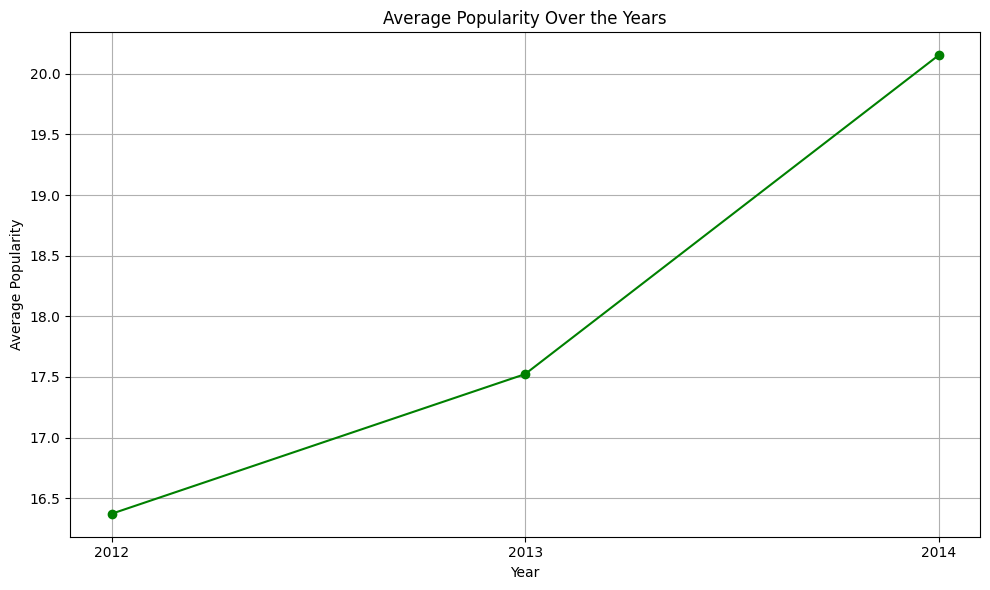

In [77]:
# Visualizing the query
result6_data = result6.toPandas()
result6_data = result6_data.dropna(subset=['year', 'avg_popularity'])
plt.figure(figsize=(10, 6))
plt.plot(result6_data['year'], result6_data['avg_popularity'], marker='o', color='green', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.title('Average Popularity Over the Years')
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# 7. List the top 5 tracks having hihest danceability
result7 = df.select("artist_name", "track_name", "danceability").orderBy(desc("danceability")).limit(5)
result7.show()

+----------------+--------------------+------------+
|     artist_name|          track_name|danceability|
+----------------+--------------------+------------+
|     Traditional|"Gambia: ""For th...|       sleep|
| Santino Fontana|               """Me|  show-tunes|
|Дмитрий Харатьян|"Не вешать нос - ...|     romance|
| Maria Maksakova|"La Nuit de Mai: ...|     romance|
|Дмитрий Харатьян|"Песня о любви - ...|     romance|
+----------------+--------------------+------------+



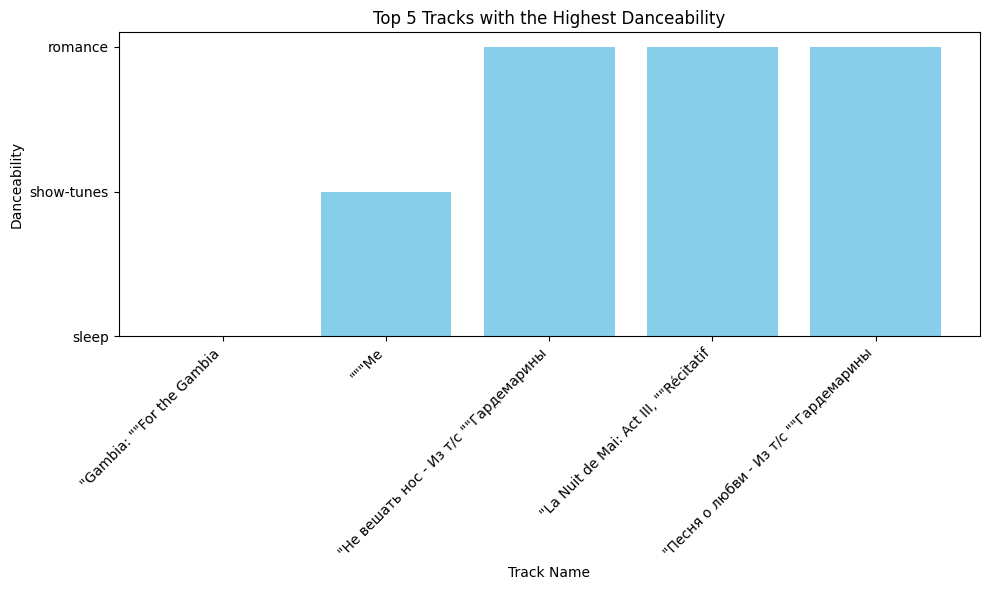

In [84]:
result7_data = result7.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(result7_data['track_name'], result7_data['danceability'], color='skyblue')
plt.xlabel('Track Name')
plt.ylabel('Danceability')
plt.title('Top 5 Tracks with the Highest Danceability')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [80]:
# 8. Identify trends in the music by displaying average duration spent by users on that particular genre
result8 = (
    df.groupBy("genre")
    .agg(avg("duration_ms").alias("avg_duration"))
    .orderBy(desc("avg_duration"))
)
result8.show()

+-----------------+------------------+
|            genre|      avg_duration|
+-----------------+------------------+
|   minimal-techno|420782.23021582735|
|            sleep|417683.10538243625|
|    chicago-house| 407084.9426229508|
|       deep-house| 398697.3596730245|
|   detroit-techno| 384258.9696048632|
|           indian| 383988.8600566572|
|progressive-house|364828.54103671707|
|      black-metal|329511.96540880506|
|    drum-and-bass| 329431.2284325638|
|           trance| 318424.6257861635|
|           techno| 317031.1551724138|
|        breakbeat|307365.98918918916|
|       psych-rock|304375.40867810295|
|           groove|301206.52254249813|
|        hardstyle| 298395.1621975147|
|            house| 296110.5765472313|
|         pop-film| 294798.5399622404|
|       electronic| 294630.3161209068|
|          ambient|291849.88842760766|
|          dubstep|291792.88779284834|
+-----------------+------------------+
only showing top 20 rows



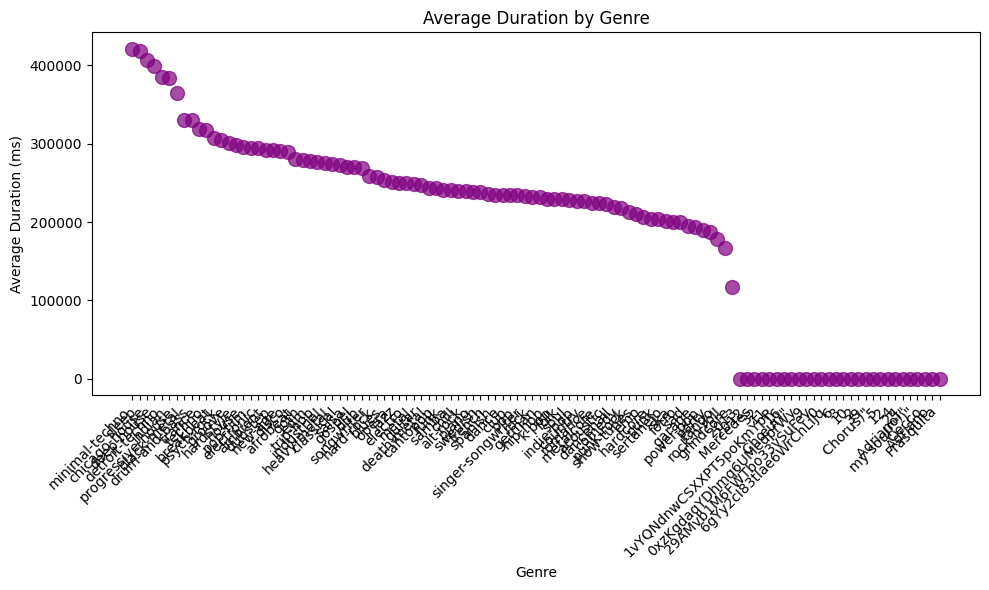

In [83]:
# Visualizing the query
result8_data = result8.toPandas()
result8_data = result8_data.dropna(subset=['genre']) # Here the missing values are handled
plt.figure(figsize=(10, 6))
plt.scatter(result8_data['genre'], result8_data['avg_duration'], color='purple', s=100, alpha=0.7)
plt.xlabel('Genre')
plt.ylabel('Average Duration (ms)')
plt.title('Average Duration by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [82]:
# 9. Predict the poularity based on loudness of a track
result9 = (
    df.groupBy("mode")
    .agg(avg("popularity").alias("avg_popularity"), avg("loudness").alias("avg_loudness"))
)
result9.show()

+-------+--------------+-------------------+
|   mode|avg_popularity|       avg_loudness|
+-------+--------------+-------------------+
|-25.177|          NULL|                6.0|
| -9.387|          NULL|                4.0|
|-17.887|          NULL|                4.0|
|-23.599|          NULL|                5.0|
|      7|          NULL|0.43000000000000005|
|-20.631|          NULL|                3.0|
|-22.162|          NULL|                1.0|
|-14.622|          NULL|                8.0|
| -9.296|          NULL|                7.0|
|-13.986|          NULL|                0.0|
| -9.902|          NULL|                7.0|
|   2012|          NULL|                8.0|
|     11|          NULL|              0.257|
|-22.917|          NULL|                8.0|
|-11.334|          NULL|                4.0|
|-11.754|          NULL|                5.0|
|-12.327|          NULL|               10.0|
|-20.893|          NULL|                5.0|
| -9.124|          NULL|                2.0|
|-14.013| 

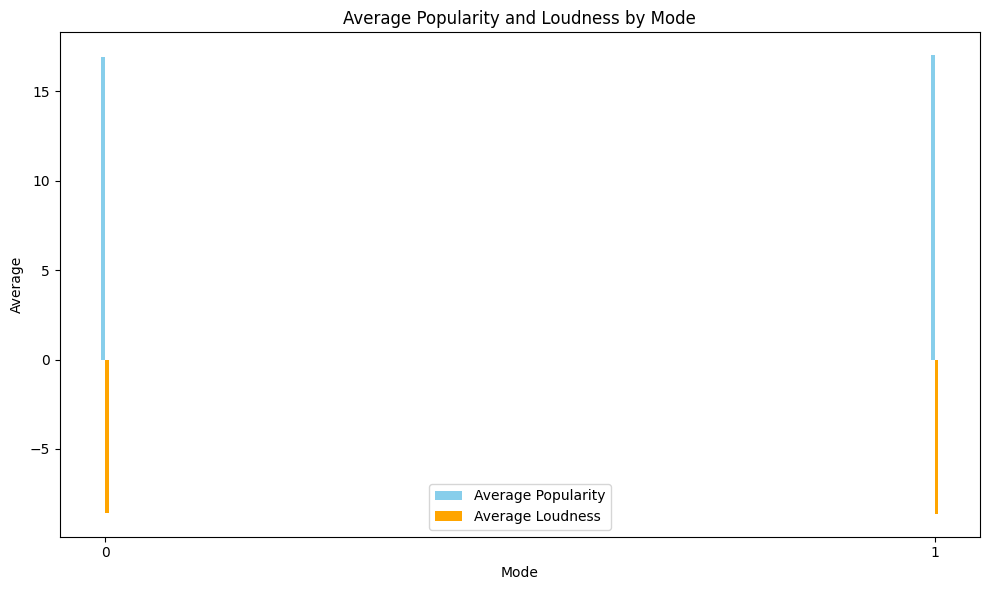

In [85]:
# Visualizing the query
result9_data = result9.toPandas()
result9_data = result9_data.dropna(subset=['mode', 'avg_popularity', 'avg_loudness']) #Handled missing values
result9_data['mode'] = result9_data['mode'].astype(str)
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
ax.bar(result9_data.index, result9_data['avg_popularity'], bar_width, label='Average Popularity', color='skyblue')
ax.bar(result9_data.index + bar_width, result9_data['avg_loudness'], bar_width, label='Average Loudness', color='orange')
ax.set_xlabel('Mode')
ax.set_ylabel('Average')
ax.set_title('Average Popularity and Loudness by Mode')
ax.set_xticks(result9_data.index + bar_width / 2)
ax.set_xticklabels(result9_data['mode'])
ax.legend()
plt.tight_layout()
plt.show()

In [86]:
# 10. List the top 5 tracks according to the highest tempo produced by the artists
result10 = df.select("artist_name", "track_name", "tempo").orderBy(desc("tempo")).limit(5)
result10.show()

+---------------+--------------------+-------+
|    artist_name|          track_name|  tempo|
+---------------+--------------------+-------+
|  Stacey Pullen|Circus Act - Orig...|247.936|
|    The Pebbles|   The Pebbles Twist|232.814|
| Audra McDonald|              Virtue|232.602|
|  Flux Pavilion|       Blow the Roof|220.169|
|Claro Intelecto|            Reformed|220.041|
+---------------+--------------------+-------+



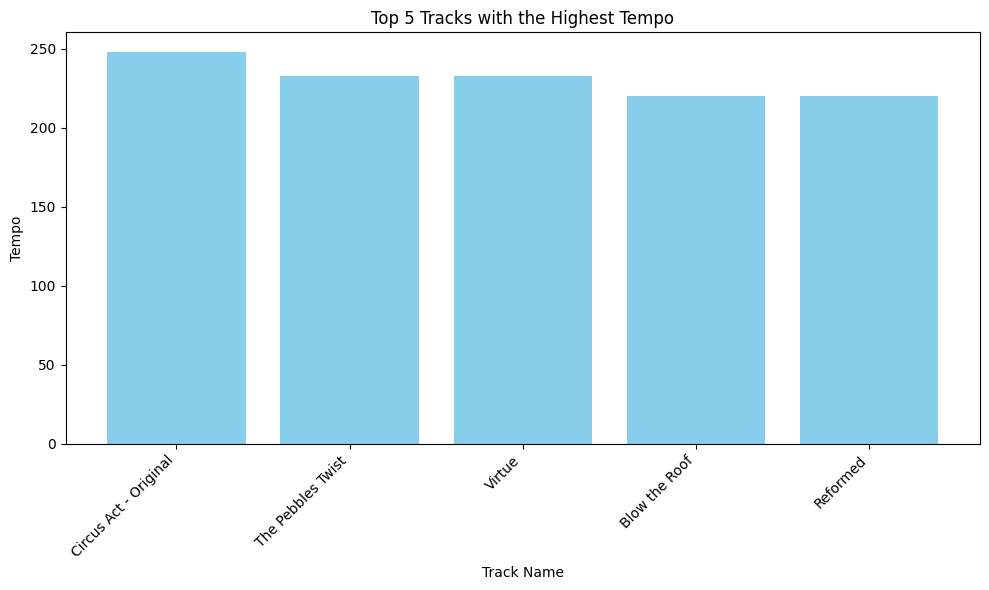

In [87]:
result10_data = result10.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(result10_data['track_name'], result10_data['tempo'], color='skyblue')
plt.xlabel('Track Name')
plt.ylabel('Tempo')
plt.title('Top 5 Tracks with the Highest Tempo')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [57]:
# 1. Train the model using random forest classifier
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()
hdfs_path = "/group19dir/spotifydataset.csv"
spotifyData = spark.read.csv("file://" + hdfs_path, header=True, inferSchema=True)
string_columns = ["danceability", "key", "loudness", "mode", "acousticness",
                  "instrumentalness", "liveness"]
for col in string_columns:
    spotifyData = spotifyData.withColumn(col, spotifyData[col].cast("double"))
labelIndexer = StringIndexer(inputCol="genre", outputCol="label", handleInvalid="skip").fit(spotifyData)
featureCols = ["danceability", "key", "loudness", "mode", "acousticness",
               "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
assembler = VectorAssembler(inputCols=featureCols, outputCol="features", handleInvalid="skip")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])
model = pipeline.fit(spotifyData)
predictions = model.transform(spotifyData)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.17594413489202082
Precision: 0.1266325650965486
Recall: 0.1759441348920208
F1 Score: 0.11698834996120679


In [61]:
#2. Train the model using Decision Tree classifier
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession.builder.appName("DecisionTreeExample").getOrCreate()
hdfs_path = "/group19dir/spotifydataset.csv"
spotifyData = spark.read.csv("file://" + hdfs_path, header=True, inferSchema=True)
string_columns = ["danceability", "key", "loudness", "mode", "acousticness",
                  "instrumentalness", "liveness"]
for col in string_columns:
    spotifyData = spotifyData.withColumn(col, spotifyData[col].cast("double"))
labelIndexer = StringIndexer(inputCol="genre", outputCol="label", handleInvalid="skip").fit(spotifyData)
featureCols = ["danceability", "key", "loudness", "mode", "acousticness",
               "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
assembler = VectorAssembler(inputCols=featureCols, outputCol="features", handleInvalid="skip")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)
pipeline = Pipeline(stages=[labelIndexer, assembler, dt])
model = pipeline.fit(spotifyData)
predictions = model.transform(spotifyData)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
spark.stop()

Accuracy: 0.1259696274445537
Precision: 0.07197452663131722
Recall: 0.1259696274445537
F1 Score: 0.07230124668342831


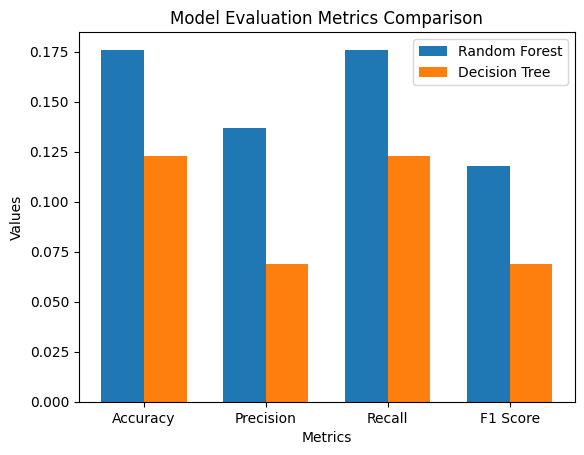

In [60]:
# Visualing Evaluation metrics of training Models
import matplotlib.pyplot as plt
rf_metrics = {
    'Accuracy': 0.176,
    'Precision': 0.137,
    'Recall': 0.176,
    'F1 Score': 0.118
}
dt_metrics = {
    'Accuracy': 0.123,
    'Precision': 0.069,
    'Recall': 0.123,
    'F1 Score': 0.069
}
metrics_names = list(rf_metrics.keys())
rf_values = list(rf_metrics.values())
dt_values = list(dt_metrics.values())
bar_width = 0.35
index = range(len(metrics_names))
fig, ax = plt.subplots()
bar1 = ax.bar(index, rf_values, bar_width, label='Random Forest')
bar2 = ax.bar([i + bar_width for i in index], dt_values, bar_width, label='Decision Tree')
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Model Evaluation Metrics Comparison')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metrics_names)
ax.legend()
plt.show()